# Parking Occupancy Detection

## Download the dataset
Website: https://web.inf.ufpr.br/vri/databases/parking-lot-database/

Dataset: http://www.inf.ufpr.br/vri/databases/PKLot.tar.gz

In [44]:
from pathlib import Path
import os

In [45]:
%%time
dataset_folder = Path('/content/PKLot')
if dataset_folder.exists():
  print('Folder already exists. Cancelling download')
else:
  # use wget to download the data
  !wget http://www.inf.ufpr.br/vri/databases/PKLot.tar.gz

Folder already exists. Cancelling download
CPU times: user 1.63 ms, sys: 80 µs, total: 1.71 ms
Wall time: 1.74 ms


In [46]:
%%time

# Extract the data with tar
!tar -xzvf PKLot.tar.gz > unzip_log.txt &

CPU times: user 520 ms, sys: 58.7 ms, total: 579 ms
Wall time: 2min 20s


In [47]:
# Checking the progress of the database
!wc -l unzip_log.txt

721277 unzip_log.txt


In [48]:
#Last 10 outputs in
!tail unzip_log.txt

PKLot/PKLotSegmented/PUC/Cloudy/2012-09-28/Empty/2012-09-28_16_01_25#051.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-10-29/Occupied/2012-10-29_17_43_28#024.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-10-13/Empty/2012-10-13_16_39_00#055.jpg
PKLot/PKLot/PUCPR/Sunny/2012-10-15/2012-10-15_06_15_41.jpg
PKLot/PKLotSegmented/PUC/Rainy/2012-11-09/Empty/2012-11-09_15_41_57#016.jpg
PKLot/PKLotSegmented/PUC/Rainy/2012-10-11/Occupied/2012-10-11_13_41_47#050.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-09-17/Empty/2012-09-17_12_49_07#002.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-09-16/Empty/2012-09-16_16_38_20#050.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-09-21/Occupied/2012-09-21_15_35_34#035.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-11-08/Empty/2012-11-08_13_05_43#077.jpg


## Exploring the dataset

After downloading we should see our what's inside our dataset. What's stored, how is it stored and rest. We should truly become one with the data

### Let's see how our dataset is stored

We will use `os.walk()` to walkthrough the dataset folder, its sub-folder, images and other information

In [49]:
import os

def walkthrough_dir(dir_path):
    """Walks through dir_path returning its contents."""
    extension_counts = {}

    for dirpath, dirnames, filenames in os.walk(dir_path):
        dir_count = len(dirnames)
        file_count = len(filenames)

        print(f"There are {dir_count} directories and {file_count} files in '{dirpath}'.")

        # Count files based on their extensions
        for filename in filenames:
            _, extension = os.path.splitext(filename)
            extension = extension.lower()  # Convert to lowercase for case-insensitive comparison
            extension_counts[extension] = extension_counts.get(extension, 0) + 1

    # Print counts based on extensions
    print("\nFile counts based on extensions:")
    for extension, count in extension_counts.items():
        print(f"{extension}: {count} files")

In [50]:
walkthrough_dir(dataset_folder)

There are 2 directories and 3 files in '/content/PKLot'.
There are 3 directories and 0 files in '/content/PKLot/PKLotSegmented'.
There are 3 directories and 0 files in '/content/PKLot/PKLotSegmented/UFPR04'.
There are 14 directories and 0 files in '/content/PKLot/PKLotSegmented/UFPR04/Rainy'.
There are 2 directories and 0 files in '/content/PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-21'.
There are 0 directories and 228 files in '/content/PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-21/Empty'.
There are 0 directories and 751 files in '/content/PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-21/Occupied'.
There are 2 directories and 0 files in '/content/PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-18'.
There are 0 directories and 952 files in '/content/PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-18/Empty'.
There are 0 directories and 165 files in '/content/PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-18/Occupied'.
There are 2 directories and 0 files in '/content/PKLot/PKLotSegmented/UFPR04/Rainy/2012-12-2

### Getting Paths

With `walkthrough_dir()` function we got to see that PKLot is divided into two parts
* PKLot where images from two locations (`PUCPR`,`UFPR`) and two camera angle for one location(`UFPR04`, `UFPR05`),
which is further divided according to weather(`Cloudy`, `Rainy`, `Sunny`) and each of them is divided according to date, and for file name its date & time. And every image has its annotations on xml file.The heirachy goes like this:
> `content/PKLot/PKLot/Location/Weather/Date/Date&Time.jpg`
> `content/PKLot/PKLot/Location/Weather/Date/Date&Time.xml`

* PKLotSegmented where each annotated bounding box in each image from the PKLot is extracted as an image and stored in two folders, `Occupied` and `Empty`. The heirachy goes like this:
> `content/PKLot/PKLotSegmented/Location/Weather/Date/Occupancy/Date&Time.jpg`

Now Let's get paths of images and xml in `/content/PKLot/PKLot` and paths of images in `/content/PKLot/PKLotSegmented`

In [51]:
%%time
# Read the content of nohup.out file
with open('unzip_log.txt', 'r') as file:
    lines = file.readlines()

# Extract paths from the lines
paths = [line.strip() for line in lines]

# Categorize paths based on patterns
category1_paths = [path for path in paths if "PKLotSegmented" in path and path.endswith(".jpg")]
category2_paths = [path for path in paths if "PKLot" in path and "PKLotSegmented" not in path and path.endswith(".jpg")]
category3_paths = [path for path in paths if "PKLot" in path and path.endswith(".xml")]
other_paths = [path for path in paths if not (path.endswith(".jpg") or path.endswith(".xml"))]

# Print the categorized paths
print("Total Paths")
print(len(paths))

print("\nCategory 1 (PKLotSegmented/*.jpg):")
print(len(category1_paths))

print("\nCategory 2 (PKLot/*.jpg):")
print(len(category2_paths))

print("\nCategory 3 (PKLot/*.xml):")
print(len(category3_paths))

print("\nOther paths:")
print(len(other_paths))

Total Paths
721277

Category 1 (PKLotSegmented/*.jpg):
695851

Category 2 (PKLot/*.jpg):
12417

Category 3 (PKLot/*.xml):
12416

Other paths:
593
CPU times: user 560 ms, sys: 97.1 ms, total: 657 ms
Wall time: 660 ms


In [52]:
type(paths)

list

In [53]:
category1_paths[:10]

['PKLot/PKLotSegmented/PUC/Rainy/2012-10-25/Occupied/2012-10-25_19_38_54#050.jpg',
 'PKLot/PKLotSegmented/PUC/Sunny/2012-09-17/Occupied/2012-09-17_08_33_55#036.jpg',
 'PKLot/PKLotSegmented/UFPR05/Cloudy/2013-03-15/Occupied/2013-03-15_08_15_02#040.jpg',
 'PKLot/PKLotSegmented/PUC/Sunny/2012-09-19/Empty/2012-09-19_17_53_47#089.jpg',
 'PKLot/PKLotSegmented/PUC/Cloudy/2012-10-31/Empty/2012-10-31_11_13_12#067.jpg',
 'PKLot/PKLotSegmented/UFPR05/Cloudy/2013-03-12/Occupied/2013-03-12_07_20_01#009.jpg',
 'PKLot/PKLotSegmented/UFPR05/Sunny/2013-03-03/Empty/2013-03-03_06_45_00#033.jpg',
 'PKLot/PKLotSegmented/UFPR04/Cloudy/2012-12-15/Occupied/2012-12-15_15_00_11#004.jpg',
 'PKLot/PKLotSegmented/PUC/Rainy/2012-10-11/Occupied/2012-10-11_16_56_54#090.jpg',
 'PKLot/PKLotSegmented/UFPR04/Cloudy/2012-12-22/Empty/2012-12-22_10_10_05#019.jpg']

In [54]:
other_paths[:10]

['PKLot/PKLotSegmented/UFPR04/Sunny/2012-12-16/Occupied/',
 'PKLot/PKLotSegmented/UFPR05/Sunny/2013-03-16/Empty/',
 'PKLot/PKLot/',
 'PKLot/PKLotSegmented/UFPR05/Sunny/2013-02-28/Occupied/',
 'PKLot/PKLotSegmented/PUC/Sunny/2012-09-17/Occupied/',
 'PKLot/PKLotSegmented/PUC/Rainy/2012-09-21/Empty/',
 'PKLot/PKLotSegmented/UFPR04/Sunny/2012-12-19/Occupied/',
 'PKLot/PKLotSegmented/',
 'PKLot/PKLotSegmented/UFPR05/Sunny/2013-03-22/Occupied/',
 'PKLot/PKLotSegmented/PUC/Sunny/2012-09-29/']

In [55]:
dataset_folder

PosixPath('/content/PKLot')

In [56]:
# Getting path of segmented images
image_paths_list = list(dataset_folder.glob('*/*/*/*/*/*.jpg'))

In [57]:
print(len(image_paths_list))

695851


In [58]:
import glob

# Convert lists to sets
image_path1_set = set(map(str, image_paths_list)) # Eg. '/content/PKLot/PKLot/UFPR05/Sunny/2013-02-24/2013-02-24_10_30_04.jpg'
category2_set = set(category2_paths) # Eg. 'PKLot/PKLot/UFPR05/Sunny/2013-03-03/2013-03-03_07_45_01.jpg'

category2_set = {str(Path('/content') / Path(path)) for path in category2_set}  # adding '/content' and coverting from PossixPath to string

# Find common paths
common_paths = image_path1_set.intersection(category2_set)

# Find paths unique to each list
unique_to_image_paths = image_path1_set.difference(category2_set)
unique_to_category2_paths = category2_set.difference(image_path1_set)

# Print the results
print("Common Paths:")
print(len(common_paths))

print("\nPaths Unique to image_path_list:")
print(len(unique_to_image_paths))

print("\nPaths Unique to category2_paths:")
print(len(unique_to_category2_paths))


Common Paths:
0

Paths Unique to image_path_list:
695851

Paths Unique to category2_paths:
12417


In [59]:
# Print the first few elements of each list
print("image_path_list (first 5 elements):")
print(list(image_path1_set)[:2])

print("\ncategory1_paths (first 5 elements):")
print(list(category2_set)[:2])


image_path_list (first 5 elements):
['/content/PKLot/PKLotSegmented/UFPR05/Cloudy/2013-03-15/Occupied/2013-03-15_18_15_14#016.jpg', '/content/PKLot/PKLotSegmented/PUC/Cloudy/2012-10-14/Empty/2012-10-14_12_19_52#080.jpg']

category1_paths (first 5 elements):
['/content/PKLot/PKLot/UFPR04/Cloudy/2013-01-20/2013-01-20_12_20_08.jpg', '/content/PKLot/PKLot/UFPR05/Sunny/2013-04-10/2013-04-10_17_35_13.jpg']


In [60]:
# Getting paths of full image and their xml files
random.seed(42)
image_path_list = list(dataset_folder.glob('*/*/*/*/*.jpg'))
xml_path_list = list(dataset_folder.glob('*/*/*/*/*.xml'))

In [61]:
print(len(image_path_list), len(xml_path_list))

12417 12416


In [62]:
# Convert lists to sets for efficient matching
image_path_set = {path.stem: path for path in image_path_list}
xml_path_set = {path.stem: path for path in xml_path_list}

# Find common file names
common_file_names = image_path_set.keys() & xml_path_set.keys()

# Create pairs of corresponding paths
corresponding_paths = [(image_path_set[file_name], xml_path_set[file_name]) for file_name in common_file_names]

# Print the corresponding paths
for image_path, xml_path in corresponding_paths[:10]:
    print(f"Image Path: {image_path}\nXML Path: {xml_path}\n")


Image Path: /content/PKLot/PKLot/PUCPR/Cloudy/2012-10-13/2012-10-13_06_23_34.jpg
XML Path: /content/PKLot/PKLot/PUCPR/Cloudy/2012-10-13/2012-10-13_06_23_34.xml

Image Path: /content/PKLot/PKLot/PUCPR/Sunny/2012-10-29/2012-10-29_10_33_04.jpg
XML Path: /content/PKLot/PKLot/PUCPR/Sunny/2012-10-29/2012-10-29_10_33_04.xml

Image Path: /content/PKLot/PKLot/PUCPR/Cloudy/2012-09-16/2012-10-16_09_18_29.jpg
XML Path: /content/PKLot/PKLot/PUCPR/Cloudy/2012-09-16/2012-10-16_09_18_29.xml

Image Path: /content/PKLot/PKLot/UFPR05/Sunny/2013-14-16/2013-04-16_08_35_02.jpg
XML Path: /content/PKLot/PKLot/UFPR05/Sunny/2013-14-16/2013-04-16_08_35_02.xml

Image Path: /content/PKLot/PKLot/UFPR04/Cloudy/2012-12-14/2012-12-14_12_20_08.jpg
XML Path: /content/PKLot/PKLot/UFPR04/Cloudy/2012-12-14/2012-12-14_12_20_08.xml

Image Path: /content/PKLot/PKLot/UFPR04/Sunny/2012-12-25/2012-12-25_16_55_12.jpg
XML Path: /content/PKLot/PKLot/UFPR04/Sunny/2012-12-25/2012-12-25_16_55_12.xml

Image Path: /content/PKLot/PKLot/P

### Data Cleaning
Since we have an uneven no of XML and Image paths, let's check which doesnt have an xml file

In [63]:
def getImagesWithoutXML(path_list):
  try:
    # Create a set of all image file names (without extensions)
    all_image_file_names = {path.stem for path in path_list}

    # Find image file names without a corresponding XML file
    image_file_names_without_xml = all_image_file_names - xml_path_set.keys()

    # Create a list of image paths without XML
    image_paths_without_xml = [image_path_set[file_name] for file_name in image_file_names_without_xml]

    # Print the results
    if image_paths_without_xml:
      print("Image Paths without XML:")
      for image_path in image_paths_without_xml:
          print(image_path)

      return image_paths_without_xml
    else:
      print("No image without an XML file found")

  except Exception as e:
    print(f"Error in getImagesWithoutXML: {e}")

In [64]:
img_without_xml = getImagesWithoutXML(image_path_list)

Image Paths without XML:
/content/PKLot/PKLot/PUCPR/Sunny/2012-11-06/2012-11-06_18_48_46.jpg


Now let's delete that img without an xml file

In [65]:
if img_without_xml:
  for image_path in img_without_xml:
    try:
      os.remove(image_path)
      print(f"{image_path} deleted")
      # Remove from image_path_set
      del image_path_set[image_path.stem]
      # Remove from image_path_list
      image_path_list.remove(image_path)
    except OSError as e:
      print(f"Error deleting {image_path}: {e}")

/content/PKLot/PKLot/PUCPR/Sunny/2012-11-06/2012-11-06_18_48_46.jpg deleted


In [66]:
# Check if the file is still there, and in image_path_list and image_path_set
if img_without_xml:
  for img_path in img_without_xml:

    # in the file
    if os.path.exists(img_path):
        print(f"The file {img_path} exists.")
    else:
        print(f"The file {img_path} does not exist.")

    # In the list
    if img_path in image_path_list:
        print(f"The file {img_path} exists in image_path_list.")
    else:
        print(f"The file {img_path} does not exist in image_path_list.")

    # In the set
    if img_path in image_path_set:
        print(f"The file {img_path} exists in image_path_set.")
    else:
        print(f"The file {img_path} does not exist in image_path_set.")

The file /content/PKLot/PKLot/PUCPR/Sunny/2012-11-06/2012-11-06_18_48_46.jpg does not exist.
The file /content/PKLot/PKLot/PUCPR/Sunny/2012-11-06/2012-11-06_18_48_46.jpg does not exist in image_path_list.
The file /content/PKLot/PKLot/PUCPR/Sunny/2012-11-06/2012-11-06_18_48_46.jpg does not exist in image_path_set.


In [67]:
getImagesWithoutXML(image_path_list)

No image without an XML file found


### Show an image

In [68]:
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.image as mpimg
import random

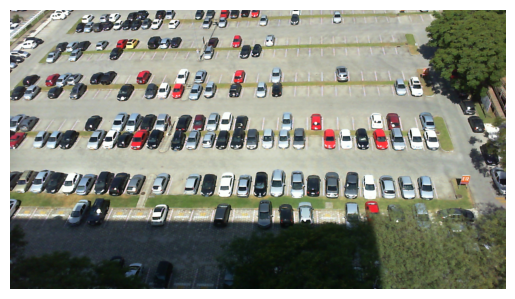

In [69]:
# Show an image
def showImage(img_path: str):
  img = mpimg.imread(img_path)

  # Display the image
  plt.imshow(img)
  plt.axis('off')
  plt.show()

random.seed(42)
random_image_path = random.choice(image_path_list)
showImage(random_image_path)

### Coding  helper functions

In [70]:
# See what XML file looks like
random_xml_path = xml_path_set[random_image_path.stem]
with open(random_xml_path) as annot_file:
    print(''.join(annot_file.readlines()))

<parking id="pucpr">
  <space id="1" occupied="1">
    <rotatedRect>
      <center x="300" y="207" />
      <size w="55" h="32" />
      <angle d="-74" />
    </rotatedRect>
    <contour>
      <point x="278" y="230" />
      <point x="290" y="186" />
      <point x="324" y="185" />
      <point x="308" y="230" />
    </contour>
  </space>
  <space id="2" occupied="0">
    <rotatedRect>
      <center x="332" y="209" />
      <size w="56" h="33" />
      <angle d="-77" />
    </rotatedRect>
    <contour>
      <point x="325" y="185" />
      <point x="355" y="185" />
      <point x="344" y="233" />
      <point x="310" y="233" />
    </contour>
  </space>
  <space id="3" occupied="1">
    <rotatedRect>
      <center x="366" y="208" />
      <size w="52" h="32" />
      <angle d="-77" />
    </rotatedRect>
    <contour>
      <point x="355" y="185" />
      <point x="388" y="186" />
      <point x="374" y="233" />
      <point x="345" y="230" />
    </contour>
  </space>
  <space id="4" 

In [71]:
# Importing the required libraries to extract information from the XML file
# import xml.etree.ElementTree as ET
from lxml import etree as ET
import math
import numpy as np

In [72]:
def loadXML(xml_path: str):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    space_data = []

    for space in root.xpath('.//space'):
        space_id = space.get('id')
        occupied_attr = space.get('occupied')

        # Check if the 'occupied' attribute exists and is not None
        if occupied_attr is None:
            # Skip to the next iteration if 'occupied' is missing or None
            continue

        occupied = int(occupied_attr)

        rotated_rect = space.find('rotatedRect')
        center = rotated_rect.find('center')
        size = rotated_rect.find('size')
        angle = rotated_rect.find('angle')

        center_x = int(float(center.get('x')))
        center_y = int(float(center.get('y')))
        size_w = int(float(size.get('w')))
        size_h = int(float(size.get('h')))
        angle_d = int(float(angle.get('d')))

        contour = space.find('contour')
        # contour_points = contour.xpath('.//point')
        contour_points = contour.xpath('.//*[translate(name(), "ABCDEFGHIJKLMNOPQRSTUVWXYZ", "abcdefghijklmnopqrstuvwxyz")="point"]')

        points = []
        for point in contour_points:
            x = int(float(point.get('x')))
            y = int(float(point.get('y')))
            points.append((x, y))

        space_data.append({
            'Space ID': space_id,
            'Occupied': occupied,
            'Center': {'x': center_x, 'y': center_y},
            'Size': {'h': size_h, 'w': size_w},
            'Angle': {'d': angle_d},
            'Contour Points': points
        })

    return space_data

parsed_random_xml = loadXML(random_xml_path)

for data in parsed_random_xml:
  print(data)
print(f"Total {len(parsed_random_xml)} parking spaces")

{'Space ID': '1', 'Occupied': 1, 'Center': {'x': 300, 'y': 207}, 'Size': {'h': 32, 'w': 55}, 'Angle': {'d': -74}, 'Contour Points': [(278, 230), (290, 186), (324, 185), (308, 230)]}
{'Space ID': '2', 'Occupied': 0, 'Center': {'x': 332, 'y': 209}, 'Size': {'h': 33, 'w': 56}, 'Angle': {'d': -77}, 'Contour Points': [(325, 185), (355, 185), (344, 233), (310, 233)]}
{'Space ID': '3', 'Occupied': 1, 'Center': {'x': 366, 'y': 208}, 'Size': {'h': 32, 'w': 52}, 'Angle': {'d': -77}, 'Contour Points': [(355, 185), (388, 186), (374, 233), (345, 230)]}
{'Space ID': '4', 'Occupied': 1, 'Center': {'x': 398, 'y': 207}, 'Size': {'h': 36, 'w': 54}, 'Angle': {'d': -79}, 'Contour Points': [(389, 185), (421, 184), (412, 232), (375, 231)]}
{'Space ID': '5', 'Occupied': 1, 'Center': {'x': 430, 'y': 210}, 'Size': {'h': 31, 'w': 50}, 'Angle': {'d': -75}, 'Contour Points': [(421, 187), (452, 190), (441, 232), (409, 231)]}
{'Space ID': '6', 'Occupied': 1, 'Center': {'x': 482, 'y': 208}, 'Size': {'h': 32, 'w': 49

In [73]:
# Now calculate the four vertices of rotated rectangle

def calculate_rotatedRect_points(center, size, angle_deg):
  # Convert the angle from degrees to radians
  angle_rad = math.radians(angle_deg)

  # Calculate half_width and half_height
  half_width = size['w'] / 2
  half_height = size['h'] / 2

  # Calculate the co-ordinates  of the four corner points
  x_center = center['x']
  y_center = center['y']

  x1 = x_center + half_width * math.cos(angle_rad) - half_height * math.sin(angle_rad)
  y1 = y_center + half_width * math.sin(angle_rad) + half_height * math.cos(angle_rad)

  x2 = x_center + half_width * math.cos(angle_rad) + half_height * math.sin(angle_rad)
  y2 = y_center + half_width * math.sin(angle_rad) - half_height * math.cos(angle_rad)

  x3 = x_center - half_width * math.cos(angle_rad) + half_height * math.sin(angle_rad)
  y3 = y_center - half_width * math.sin(angle_rad) - half_height * math.cos(angle_rad)

  x4 = x_center - half_width * math.cos(angle_rad) - half_height * math.sin(angle_rad)
  y4 = y_center - half_width * math.sin(angle_rad) + half_height * math.cos(angle_rad)

  # Return the four corner points as a list of dictionaries
  return [
      {'x': int(round(x1)), 'y': int(round(y1))},
      {'x': int(round(x2)), 'y': int(round(y2))},
      {'x': int(round(x3)), 'y': int(round(y3))},
      {'x': int(round(x4)), 'y': int(round(y4))}
  ]

print(data) # from parsed_random_xml
# occupied = data['Occupied']
center = data['Center']
size = data['Size']
angle_deg = data['Angle']['d']

print(calculate_rotatedRect_points(center, size, angle_deg))

{'Space ID': '100', 'Occupied': 1, 'Center': {'x': 653, 'y': 538}, 'Size': {'h': 54, 'w': 65}, 'Angle': {'d': -86}, 'Contour Points': [(624, 569), (629, 509), (683, 507), (679, 570)]}
[{'x': 682, 'y': 507}, {'x': 628, 'y': 504}, {'x': 624, 'y': 569}, {'x': 678, 'y': 572}]


### Image with annotations

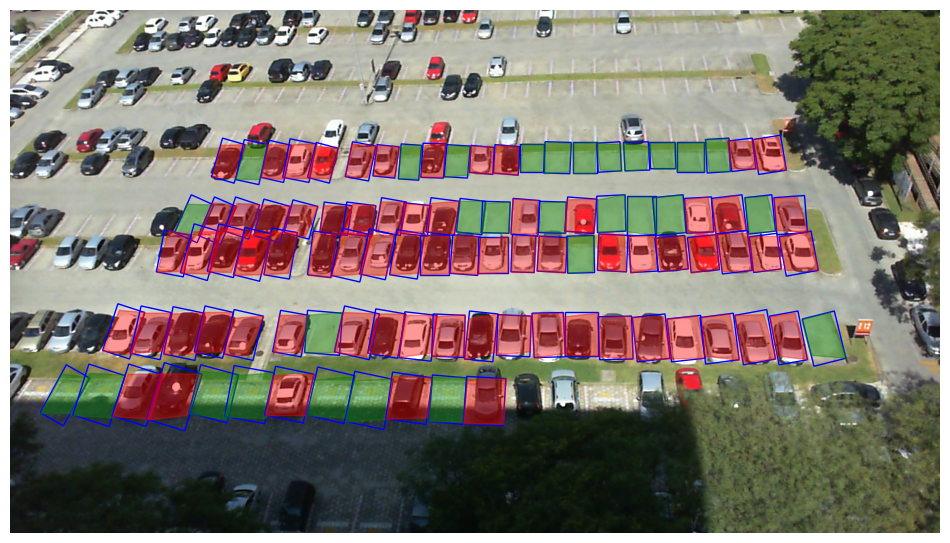

In [74]:
def imageWithAnnotations(img_path, xml_path):
  # Load XML data
  parsed_data = loadXML(xml_path)

  # Load image
  image = plt.imread(img_path)

  # Show the image & annotations
  fig, ax = plt.subplots(1, figsize=(12,12))
  ax.imshow(image)

  for space_info in parsed_data:
    # External bounding box
    center = space_info['Center']
    size = space_info['Size']
    angle_d = space_info['Angle']['d']

    rotatedRect_points = calculate_rotatedRect_points(center, size, angle_d)

    vertices = [(dictionary['x'], dictionary['y']) for  dictionary in rotatedRect_points]

    rotatedRect = Polygon(vertices, closed=True, edgecolor='blue', facecolor='none')

    ext_rect = Polygon(vertices, fill=False, color='blue')
    ax.add_patch(rotatedRect)

    # Internal Masking
    contour_points = space_info['Contour Points']
    occupied = int(space_info['Occupied'])

    color = 'red' if occupied == 1 else 'green'

    contour_polygon = Polygon(contour_points, closed=True, edgecolor=color, facecolor=color, alpha=0.4)
    ax.add_patch(contour_polygon)

  ax.axis('off')
  plt.show()

imageWithAnnotations(random_image_path, random_xml_path)

### Getting an image from a bounding box

In [75]:
import cv2
from pathlib import Path
import os

In [76]:
# Create a folder for segmented data
segmented_folder = Path('segmented_data')
if not segmented_folder.exists():
  segmented_folder.mkdir()

# Create folders for empty and occupied spaces
empty_folder = segmented_folder / 'empty'
occupied_folder = segmented_folder / 'occupied'

if not empty_folder.exists():
  empty_folder.mkdir()
if not occupied_folder.exists():
  occupied_folder.mkdir()

In [77]:
def extractImage(img_path, xml_path):
  '''This extracts an image from given bounding box vertices'''
  print(img_path)
  image = cv2.imread(str(img_path))
  parsed_data = loadXML(xml_path)

  for i, data_list in enumerate(parsed_data):
    center = data_list['Center']
    size = data_list['Size']
    angle_deg = data_list['Angle']['d']
    occupied = data_list['Occupied']
    contours = data_list['Contour Points']

    destination_folder = occupied_folder if occupied == 1 else empty_folder

    rotated_rect_points = calculate_rotatedRect_points(center, size, angle_deg)

    vertices = [(dictionary['x'], dictionary['y']) for dictionary in rotated_rect_points]
    vertices = np.array(vertices)

    # to create a bounding box with rectangle
    x_min = np.min(vertices[:, 0])
    x_max = np.max(vertices[:, 0])
    y_min = np.min(vertices[:, 1])
    y_max = np.max(vertices[:, 1])
    extracted_image = image[y_min:y_max, x_min:x_max]
    image_filename = os.path.join(destination_folder, f'object_{i}.jpg')

    cv2.imwrite(image_filename, extracted_image)



  print(rotated_rect_points)
  print(type(occupied))
  print(vertices)

# extractImage('/content/2012-12-12_12_10_07.jpg', '/content/2012-12-12_12_10_07.xml')

In [78]:
random_image_path

PosixPath('/content/PKLot/PKLot/PUCPR/Sunny/2012-11-20/2012-11-20_15_54_41.jpg')

In [79]:
%%time
extractImage(random_image_path, random_xml_path)

/content/PKLot/PKLot/PUCPR/Sunny/2012-11-20/2012-11-20_15_54_41.jpg
[{'x': 682, 'y': 507}, {'x': 628, 'y': 504}, {'x': 624, 'y': 569}, {'x': 678, 'y': 572}]
<class 'int'>
[[682 507]
 [628 504]
 [624 569]
 [678 572]]
CPU times: user 47.6 ms, sys: 3.05 ms, total: 50.7 ms
Wall time: 82.1 ms


In [80]:
random_image_path

PosixPath('/content/PKLot/PKLot/PUCPR/Sunny/2012-11-20/2012-11-20_15_54_41.jpg')

### Display all the photos in the created folder

This is not a good approach but since we are doing it on pictures from just one big image so it shouldn't be a problem

In [81]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def displayFromFolder(image_paths: list):
    '''This function displays all the images in the folder from the provided Path'''

    # Define the number of columns
    max_columns = 10

    # Calculate the number of rows needed
    if len(image_paths) > 100:
        num_images = 100
        print('Too many images, changing it to 100...')
    else:
        num_images = len(image_paths)

    # Calculate the number of rows needed
    num_columns = min(num_images, max_columns)
    num_rows = (num_images + num_columns - 1) // num_columns
    parent_dir = os.path.basename(os.path.dirname(image_paths[0]))
    plt.figure(figsize=(12,num_rows+1))
    plt.suptitle(parent_dir)

    for i, image_path in enumerate(image_paths[:num_images]):
      plt.subplot(num_rows, num_columns, i + 1)
      img = mpimg.imread(image_path)
      plt.imshow(img)
      img_title = image_path.stem if len(image_path.stem) < 11 else f'Image {i+1}'
      plt.title(img_title, fontsize=8)
      plt.axis('off')
    plt.show()

In [82]:
%%time
occupied_image_paths = list(occupied_folder.glob('*.jpg'))
empty_image_paths = list(empty_folder.glob('*.jpg'))

CPU times: user 915 µs, sys: 0 ns, total: 915 µs
Wall time: 958 µs


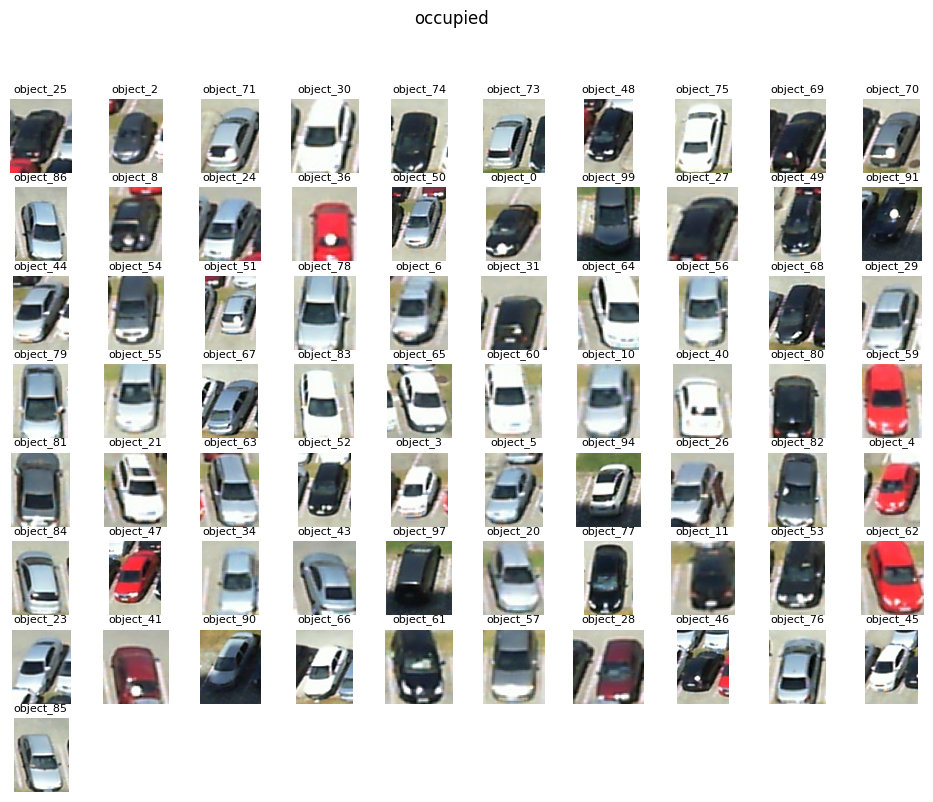

In [83]:
displayFromFolder(occupied_image_paths)

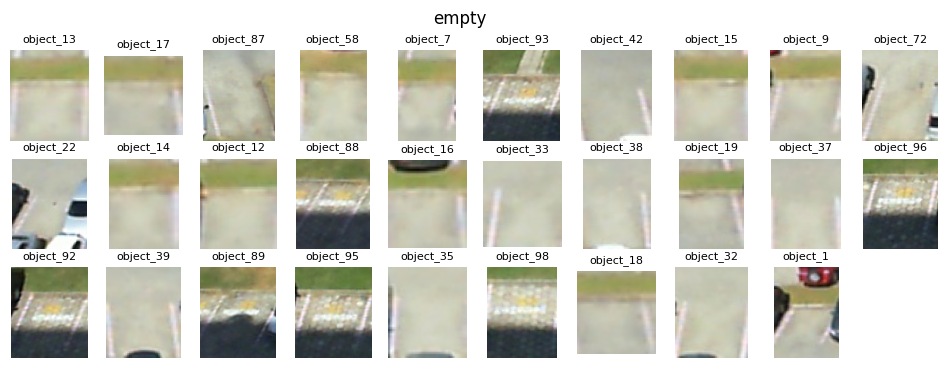

In [84]:
displayFromFolder(empty_image_paths)

### Getting image size

In [85]:
from PIL import Image

def get_image_size(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height

In [86]:
def displayImageSize(paths, num_choices=5):
  random_paths = random.sample(paths, min(num_choices, len(paths)))
  for path in random_paths:
    # print(path)
    width, height = get_image_size(path)
    print(f"Image size: {width} x {height} pixels")

In [87]:
displayImageSize(occupied_image_paths)

Image size: 54 x 74 pixels
Image size: 42 x 46 pixels
Image size: 40 x 52 pixels
Image size: 42 x 50 pixels
Image size: 56 x 74 pixels


In [88]:
displayImageSize(empty_image_paths, 10)

Image size: 32 x 50 pixels
Image size: 66 x 78 pixels
Image size: 38 x 52 pixels
Image size: 46 x 56 pixels
Image size: 40 x 50 pixels
Image size: 34 x 48 pixels
Image size: 60 x 76 pixels
Image size: 40 x 52 pixels
Image size: 68 x 84 pixels
Image size: 36 x 36 pixels


### Seeing PKLotSegmented

In [89]:
%%time
import fnmatch

image_paths_list = list(dataset_folder.glob('*/*/*/*/*/*.jpg'))
# Pattern to match
pattern1 = '*/*/*/*/Empty/*.jpg'
pattern2 = '*/*/*/*/Occupied/*.jpg'

# Use fnmatch to filter paths
empty_paths = [path for path in image_paths_list if fnmatch.fnmatch(path, pattern1)]
occupied_paths = [path for path in image_paths_list if fnmatch.fnmatch(path, pattern2)]

CPU times: user 8.12 s, sys: 428 ms, total: 8.54 s
Wall time: 8.62 s


In [90]:
len(empty_paths), len(occupied_paths)

(358071, 337780)

Too many images, changing it to 100...


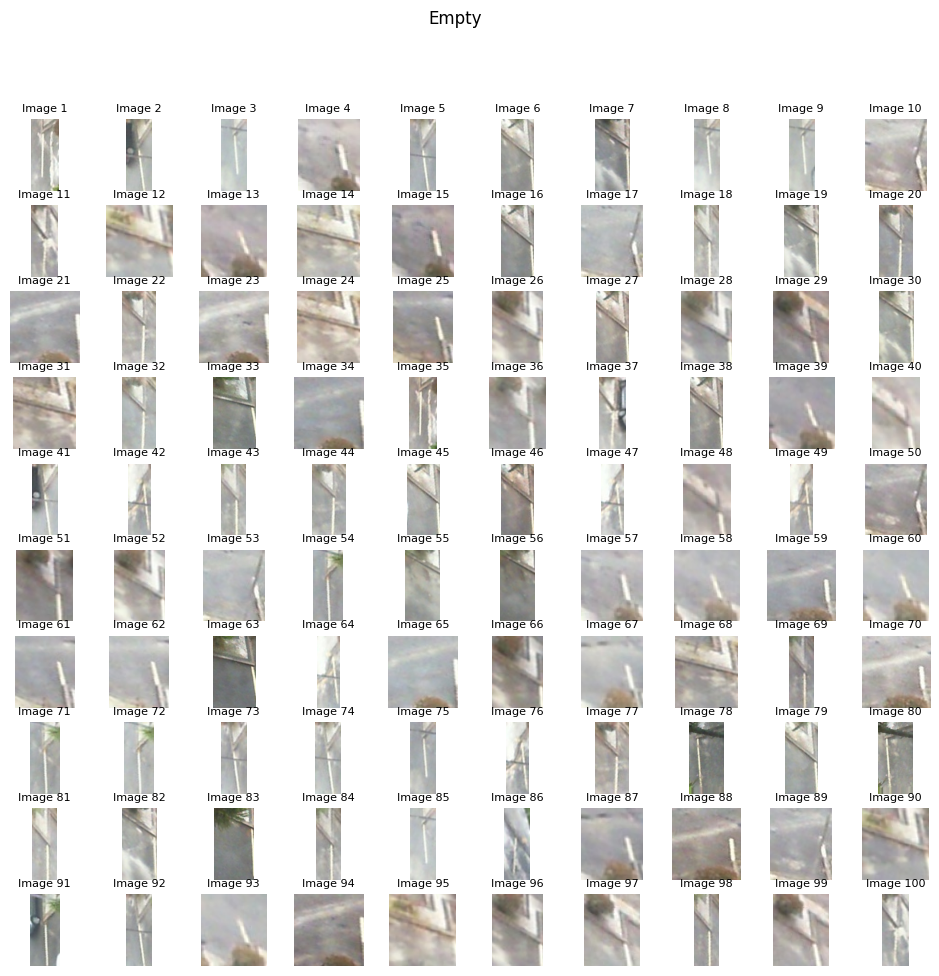

In [91]:
displayFromFolder(empty_paths)

Too many images, changing it to 100...


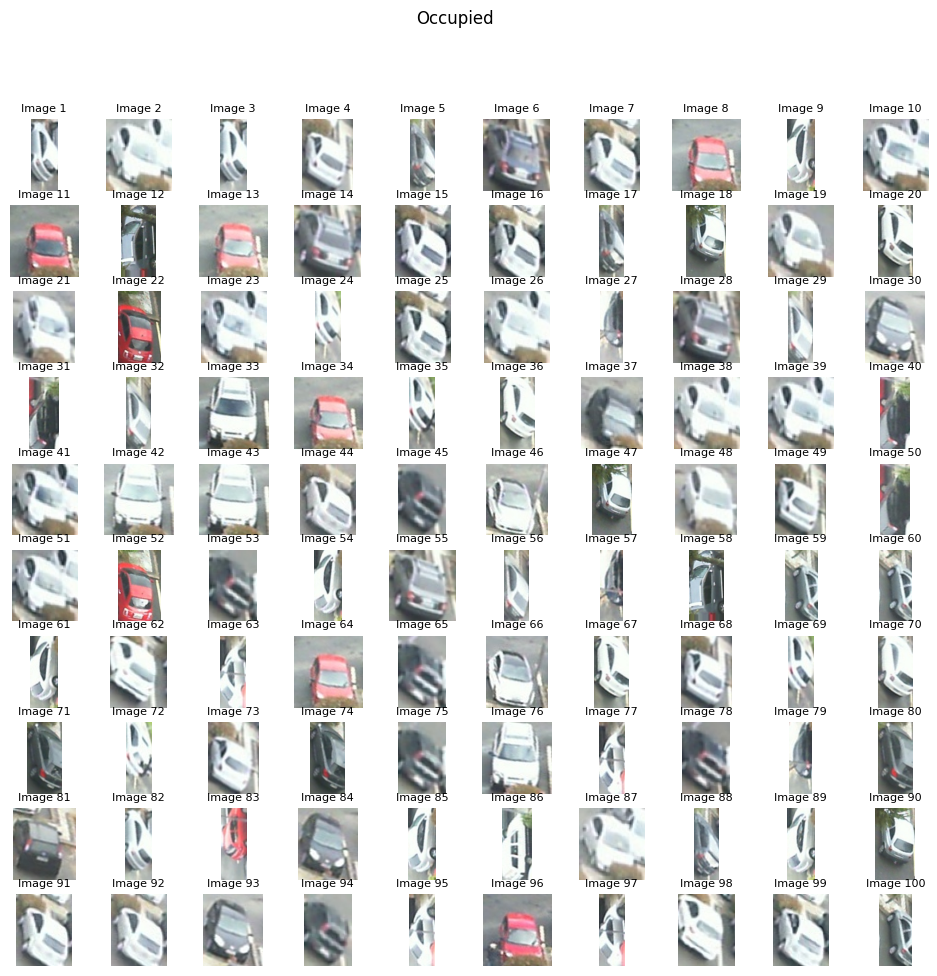

In [92]:
displayFromFolder(occupied_paths)

In [93]:
displayImageSize(occupied_paths)

Image size: 29 x 93 pixels
Image size: 42 x 51 pixels
Image size: 37 x 50 pixels
Image size: 31 x 50 pixels
Image size: 48 x 67 pixels


In [94]:
displayImageSize(empty_paths)

Image size: 41 x 88 pixels
Image size: 83 x 141 pixels
Image size: 31 x 84 pixels
Image size: 45 x 69 pixels
Image size: 48 x 109 pixels


## Custom Dataset

### Splitting the dataset

In [95]:
def custom_train_test_validation_split(image_paths, test_size: float = 0.2, val_size: float = 0.1, random_state: int = 42):
  """
    Custom function to generate train, test, and validation splits for image paths using randomization.

    Parameters:
    - img_paths: List of image file paths
    - test_size: The proportion of the dataset to include in the test split (default is 0.2)
    - val_size: The proportion of the dataset to include in the validation split (default is 0.1)
    - random_state: Seed for random number generation to ensure reproducibility (default is None)

    Returns:
    - img_paths_train, img_paths_test, img_paths_val: Split paths
    """
  if random_state:
    random.seed(random_state)
  random.shuffle(image_paths)

  # Calculate split indices
  total_samples = len(image_paths)
  test_split_idx = int(total_samples * (1 - test_size - val_size))
  val_split_idx = int(total_samples * (1 - val_size))

  # Split the dataset
  img_paths_train = image_paths[:test_split_idx]
  img_paths_test = image_paths[test_split_idx:val_split_idx]
  img_paths_val = image_paths[val_split_idx:]

  return img_paths_train, img_paths_test, img_paths_val

In [96]:
image_paths_train, image_paths_test, image_paths_val = custom_train_test_validation_split(image_paths_list)

In [97]:
len(image_paths_train), len(image_paths_test), len(image_paths_val)

(487095, 139170, 69586)

Too many images, changing it to 100...


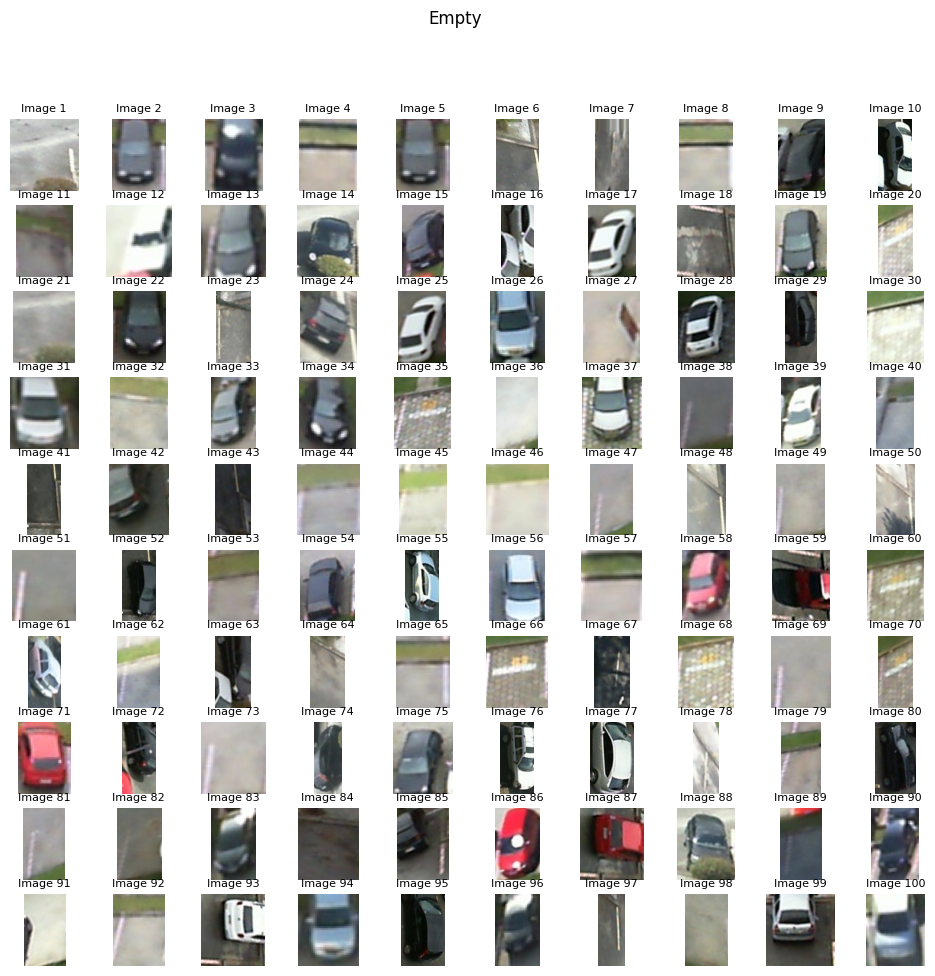

In [98]:
displayFromFolder(image_paths_train)

### PKLotSegmented Dataset

In [99]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from glob import glob

In [100]:
# class PKLotSegmentedDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform

#         # Define patterns for Empty and Occupied images
#         self.empty = os.path.join(root_dir, '*/*/*/*/Empty/*.jpg')
#         self.occupied = os.path.join(root_dir, '*/*/*/*/Occupied/*.jpg')

#         # Get file paths based on patterns
#         self.empty_paths = glob(self.empty)
#         self.occupied_paths = glob(self.occupied)

#         # Combine the paths
#         self.image_paths = self.empty_paths + self.occupied_paths

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, index):
#         img_path = self.image_paths[index]

#         # Load the image
#         image = Image.open(img_path).convert("RGB")

#         # Apply transform
#         if self.transform:
#             image = self.transform(image)

#         # Determine the label based on the path
#         label = 0 if 'Empty' in img_path else 1  # 0 for Empty, 1 for Occupied

#         # Return the image, label, and associated information
#         return image, label

In [101]:
class PKLotSegmentedDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

        # Determine classes and store them as an attribute
        self.classes, self.class_to_idx = self.find_classes()

    def find_classes(self):
        # Assuming your classes are determined based on the patterns in the image paths
        classes = set()
        for img_path in self.image_paths:
            # Extract the class label from the image path
            label = 'Empty' if 'Empty' in str(img_path) else 'Occupied'
            classes.add(label)

        # Convert set to list and sort
        classes = sorted(list(classes))
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return classes, class_to_idx

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transform
        if self.transform:
            image = self.transform(image)

        # Determine the label based on the path
        label = 0 if 'Empty' in str(img_path) else 1  # 0 for Empty, 1 for Occupied

        # Return the image, label, and associated information
        return image, label

In [102]:
# Train transform
train_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])

In [103]:
train_dataset = PKLotSegmentedDataset(image_paths_train, transform=train_transform)

In [104]:
img, info = train_dataset[0]

(-0.5, 31.5, 31.5, -0.5)

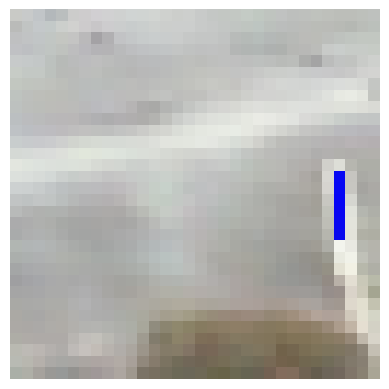

In [105]:
image_np = img.numpy().transpose(1, 2, 0)
plt.imshow(image_np)
plt.axis('off')

In [106]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  '''
  Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version.
  '''

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      #  Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # Note we will need to change the shape
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

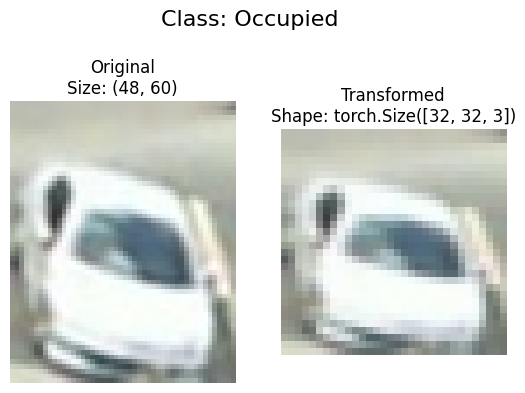

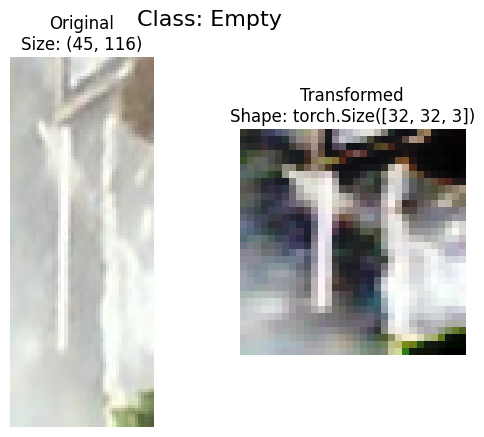

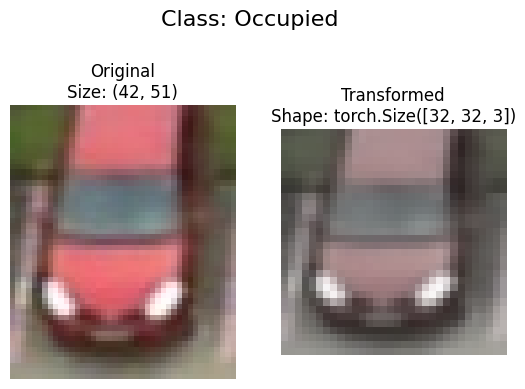

In [107]:
# plot random transformed images
plot_transformed_images(
    image_paths= image_paths_train,
    transform= train_transform,
    n = 3,
    seed = None
)

### DataLoader

In [108]:
train_dataset = PKLotSegmentedDataset(image_paths_train,
                             transform=train_transform)

test_dataset = PKLotSegmentedDataset(image_paths_test,
                            transform=test_transform)

val_dataset = PKLotSegmentedDataset(image_paths_val,
                           transform=val_transform)

In [109]:
train_loader = DataLoader(train_dataset,
                          batch_size=64,
                          num_workers=os.cpu_count(),
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=64,
                         num_workers=0,
                         shuffle=False)

val_loader = DataLoader(val_dataset,
                        batch_size=64,
                        num_workers=os.cpu_count(),
                        shuffle=False)

In [110]:
os.cpu_count()

2

In [111]:
len(train_dataset), len(test_dataset), len(val_dataset)

(487095, 139170, 69586)

## Building models




In [185]:
import torch
from torch import nn
from torch.optim import lr_scheduler

torch.__version__

'2.1.0+cu118'

In [113]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Tiny VGG model class

In [140]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*8*8,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

# Create an instance of the model
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_dataset.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=2, bias=True)
  )
)

### CarDetectorModel0

In [115]:
class CarDetectorModel0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*8*8,
                      out_features=output_shape)
        )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

# Create Instance of the model
torch.manual_seed(42)
model_0 = CarDetectorModel0(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_dataset.classes)).to(device)
model_0

CarDetectorModel0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=2, bias=True)
  )
)

### Try a forward pass on a single image (to test the model)


In [116]:
# Get a single image batch
image_batch, label_batch = next(iter(train_loader))
image_batch.shape, label_batch.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [117]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[-0.0088, -0.0335],
        [-0.0091, -0.0506],
        [-0.0065, -0.0565],
        [-0.0230, -0.0483],
        [-0.0197, -0.0586],
        [-0.0302, -0.0336],
        [-0.0226, -0.0631],
        [-0.0018, -0.0487],
        [-0.0174, -0.0390],
        [-0.0315, -0.0684],
        [-0.0252, -0.0460],
        [-0.0182, -0.0331],
        [-0.0154, -0.0388],
        [-0.0258, -0.0327],
        [-0.0233, -0.0723],
        [-0.0173, -0.0396],
        [-0.0007, -0.0455],
        [-0.0153, -0.0370],
        [-0.0115, -0.0534],
        [-0.0265, -0.0782],
        [-0.0240, -0.0757],
        [-0.0160, -0.0477],
        [-0.0222, -0.0682],
        [-0.0260, -0.0613],
        [-0.0100, -0.0505],
        [-0.0128, -0.0596],
        [-0.0227, -0.0344],
        [-0.0210, -0.0369],
        [-0.0137, -0.0407],
        [-0.0208, -0.0613],
        [-0.0286, -0.0521],
        [-0.0270, -0.0624],
        [-0.0174, -0.0323],
        [-0.0086, -0.0676],
        [-0.0223, -0.0675],
        [-0.0074, -0

### Use `torchinfo` to get an idea of the shapes going through our model

In [139]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 32, 32]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
CarDetectorModel0                        [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 10, 32, 32]           280
│    └─ReLU: 2-2                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-3                    [1, 10, 16, 16]           --
├─Sequential: 1-2                        [1, 10, 8, 8]             --
│    └─Conv2d: 2-4                       [1, 10, 16, 16]           910
│    └─ReLU: 2-5                         [1, 10, 16, 16]           --
│    └─MaxPool2d: 2-6                    [1, 10, 8, 8]             --
├─Sequential: 1-3                        [1, 2]                    --
│    └─Flatten: 2-7                      [1, 640]                  --
│    └─Linear: 2-8                       [1, 2]                    1,282
Total params: 2,472
Trainable params: 2,472
Non-trainable params: 0
Total mult-a

### Create train & test loop functions

* `train_step()` - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
* `test_step()` - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
* `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.




In [119]:
from tqdm.auto import tqdm

In [182]:
# Create  train function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler = None,
               device=device):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches"
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    if scheduler:
      # Update the learning rate at the end of each epoch
      scheduler.step()

      # Access the current learning rate if needed
      current_lr = optimizer.param_groups[0]['lr']

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [121]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in tqdm(enumerate(dataloader)):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### Creating a `train()` function to combine `train_step()` and `test_step()`


In [186]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler : torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       scheduler=scheduler,
                                       device = device)

    test_loss, test_acc = test_step(model=model,
                                     dataloader=test_dataloader,
                                     loss_fn=loss_fn,
                                     device = device)

    # 4. Print out what's happening
    print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

In [123]:
class_names = train_dataset.classes
class_names

['Empty', 'Occupied']

## Train the model

### Smaller DataLoader



Since its too large we will split the image_paths_test into smaller train, test and validation set

In [143]:
len(image_paths_test)

139170

In [144]:
image_train_m, image_test_m, image_val_m = custom_train_test_validation_split(image_paths_test)

In [145]:
len(image_train_m), len(image_test_m), len(image_val_m)

(97419, 27834, 13917)

In [146]:
train_dataset_m = PKLotSegmentedDataset(image_train_m,
                             transform=train_transform)

test_dataset_m = PKLotSegmentedDataset(image_test_m,
                            transform=test_transform)

val_dataset_m = PKLotSegmentedDataset(image_val_m,
                           transform=val_transform)

In [147]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 64

train_loader_m = DataLoader(train_dataset_m,
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

test_loader_m = DataLoader(test_dataset_m,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         shuffle=False)

val_loader_m = DataLoader(val_dataset_m,
                        batch_size=1,
                        num_workers=NUM_WORKERS,
                        shuffle=False)

In [148]:
len(train_dataset_m), len(train_loader_m) * BATCH_SIZE

(97419, 97472)

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0_1 = CarDetectorModel0(input_shape=3, # number of color channels (3 for RGB)
                            hidden_units=10,
                            output_shape=len(train_dataset_m.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0_1.parameters(), lr=0.001)

step_size = 4  # Adjust this based on your training needs
gamma = 0.1   # Factor by which the learning rate will be reduced
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_1_results = train(model=model_0_1,
                        train_dataloader=train_loader_m,
                        test_dataloader=test_loader_m,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        scheduler=scheduler,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [153]:
  model_0.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 7.6025e-02,  1.2734e-01, -6.0692e-02],
                        [ 1.4111e-01, -8.6845e-02,  2.8303e-02],
                        [-1.3468e-01,  8.0294e-02,  1.3169e-01]],
              
                       [[-7.6826e-02,  2.7731e-01,  1.5873e-01],
                        [ 2.5242e-01,  1.2992e-01,  2.2375e-01],
                        [ 6.9238e-02,  2.5828e-01,  1.2671e-01]],
              
                       [[-2.6339e-01, -8.7183e-02, -2.1307e-01],
                        [-1.2232e-01, -1.7171e-01,  6.2632e-02],
                        [-2.2471e-01, -1.2780e-01, -9.4300e-02]]],
              
              
                      [[[-1.5944e-01, -3.0869e-03, -1.7682e-01],
                        [ 1.4899e-01, -1.4720e-01,  1.6383e-01],
                        [ 4.6629e-02, -4.6581e-02,  1.4761e-01]],
              
                       [[-2.2959e-02,  1.1553e-01,  1.7974e-02],
                        [-1.1330e-01

#### Training TinyVGG

In [173]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 3

# Recreate an instance of TinyVGG
model_1 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_dataset_m.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_1_results = train(model=model_1,
                        train_dataloader=train_loader_m,
                        test_dataloader=test_loader_m,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 0.6937 | train_acc: 0.4837 | test_loss: 0.6936 | test_acc: 0.4885


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.6937 | train_acc: 0.4837 | test_loss: 0.6936 | test_acc: 0.4885


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 0.6937 | train_acc: 0.4838 | test_loss: 0.6936 | test_acc: 0.4885
Total training time: 367.968 seconds


In [174]:
model_1_results

{'train_loss': [0.6936914066851961, 0.6936979431191793, 0.6936962535642748],
 'train_acc': [0.48373145854473826, 0.48373145854473826, 0.4837808899898526],
 'test_loss': [0.6936351339022319, 0.6936351339022319, 0.6936351339022319],
 'test_acc': [0.4884698275862069, 0.4884698275862069, 0.4884698275862069]}

In [158]:
# File paths
model_00_path = Path('/content/drive/MyDrive/Minor/Models/CarDetectorModel1.pth')

# Load the entire model from the checkpoint
checkpoint = torch.load(model_00_path)

# Reconstruct the model using both the architecture and state dictionary
model_00 = checkpoint['model_architecture']
model_00.load_state_dict(checkpoint['model_state_dict'])

# Print the state_dict of the loaded model
print(model_00)

CarDetectorModel0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=2, bias=True)
  )
)


In [161]:
# File paths
model_010_path = Path('TinyVGG.pth')

# Load the entire model from the checkpoint
checkpoint = torch.load(model_010_path)

# Reconstruct the model using both the architecture and state dictionary
model_010 = checkpoint['model_architecture']
model_010.load_state_dict(checkpoint['model_state_dict'])

# Print the state_dict of the loaded model
print(model_010.state_dict())

OrderedDict([('conv_block_1.0.weight', tensor([[[[ 0.1091,  0.1844, -0.0575],
          [ 0.1168,  0.0099,  0.0328],
          [-0.1930,  0.1033,  0.1083]],

         [[-0.0848,  0.3266,  0.1660],
          [ 0.2026,  0.2492,  0.2641],
          [-0.0176,  0.2946,  0.1276]],

         [[-0.3185, -0.0431, -0.1910],
          [-0.3066, -0.1689,  0.0205],
          [-0.4371, -0.2167, -0.1903]]],


        [[[-0.3465, -0.1133, -0.2176],
          [ 0.0591, -0.2385,  0.1920],
          [ 0.1459,  0.0473,  0.2775]],

         [[-0.1535,  0.0581,  0.0540],
          [-0.1530, -0.0152,  0.0260],
          [ 0.2310,  0.3111,  0.3385]],

         [[-0.2547,  0.0084,  0.0174],
          [ 0.0138, -0.2009, -0.1575],
          [ 0.0802, -0.0185,  0.3564]]],


        [[[ 0.1008, -0.0119, -0.0926],
          [ 0.0546,  0.1453, -0.2041],
          [ 0.0780, -0.0726,  0.0486]],

         [[ 0.0879,  0.0537, -0.1407],
          [ 0.3396, -0.0184, -0.1193],
          [ 0.0844,  0.3379,  0.1328]],

     

### Plot the loss curves of Model 0
A **loss curve** is a way of tracking your model's progress over time.
A good guide for different loss curves can be seen here:
* https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic


In [133]:
from typing import Dict, List

In [134]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """
  Plots training curves of a results dictionary.

  Args:
    results (dict): dictionary containing list of values, e.g.
        {"train_loss": [...],
          "train_acc": [...],
          "test_loss": [...],
          "test_acc": [...]}
  """

  # Get the loss values of the results dictionary(Training and test)
  loss = results['train_loss']
  test_loss = results['test_loss']

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # Figure out how many epochs there were
  epochs = range(len(results['train_acc']))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

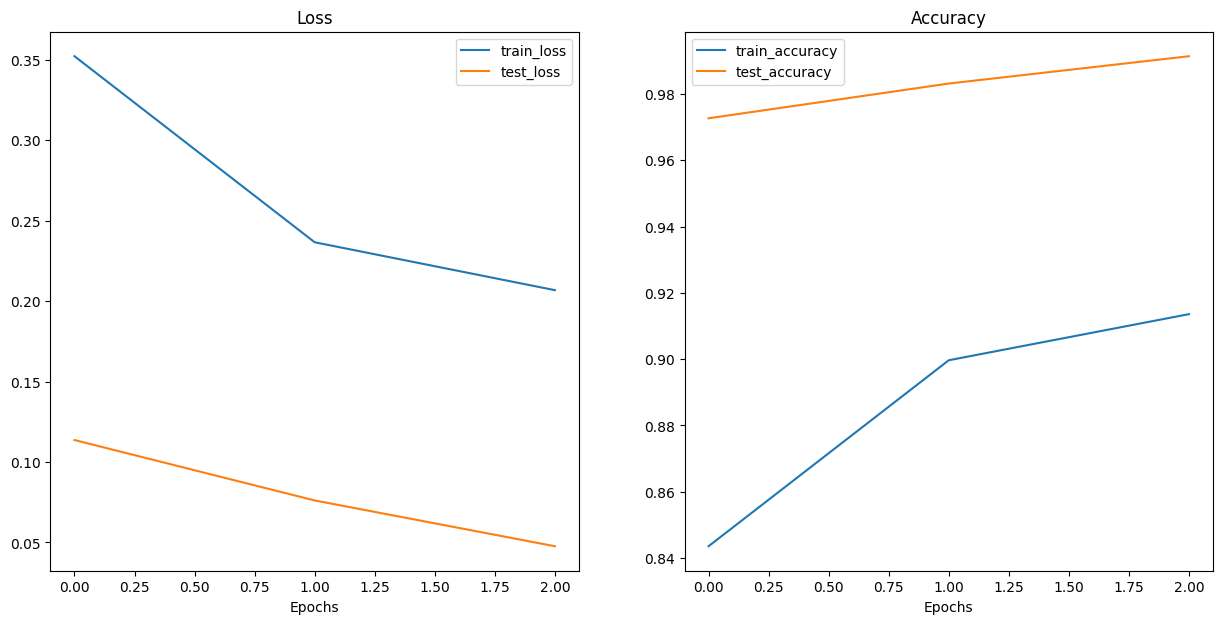

In [135]:
plot_loss_curves(model_0_results)

## Saving the model and its state dict

In [137]:
from google.colab import drive

def save_model_to_drive(model, model_name, drive_path='/content/drive/MyDrive/Minor/Models'):
    # Mount Google Drive
    drive.mount('/content/drive')

    # Create the full path for saving the model
    model_path = f'{drive_path}/{model_name}.pth'

    # Check if the folder exists, if not, create it
    if not os.path.exists(drive_path):
        os.makedirs(drive_path)

    # Save both the model architecture and state_dict to Google Drive
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': model,
    }, model_path)

    print(f'Model and its state_dict saved to: {model_path}')

In [138]:
save_model_to_drive(model_0, 'CarDetectorModel1')

Mounted at /content/drive
Model and its state_dict saved to: /content/drive/MyDrive/Minor/Models/CarDetectorModel1.pth


In [ ]:
def get_model_size(model_path):
    # Get the size of the saved model file
    model_size_bytes = os.path.getsize(model_path)
    model_size_kb = model_size_bytes / 1024
    model_size_mb = model_size_kb / 1024

    print(f'Model size: {model_size_bytes} bytes, {model_size_kb:.2f} KB, {model_size_mb:.2f} MB')

get_model_size()

## Making predictions

### In few Images

In [ ]:
random_images_path = random.sample(image_val_s, 10)
random_images_path

In [ ]:
displayFromFolder(random_images_path)

In [ ]:
model_0.eval()  # Set the model to evaluation mode

# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust size to match the input size of your model
    transforms.ToTensor(),
])

# List to store predictions
predictions = []

# Loop through each image path
for image_path in random_images_path:
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Send the image tensor to the device (CPU or GPU)
    image_tensor = image_tensor.to(device)

    # Make predictions
    with torch.inference_mode():
        model_output = model_0(image_tensor)

    # Get the predicted class (assuming your model outputs logits)
    predicted_class = torch.argmax(model_output, dim=1).item()

    # Append the prediction to the list
    predictions.append(predicted_class)

# Print the predictions
for image_path, prediction in zip(random_images_path, predictions):
    print(f"Image: {image_path}, Predicted Class: {prediction}")


### In a full DataLoader

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
def make_predictions_with_dataloader(model: nn.Module,
                                     dataloader: torch.utils.data.DataLoader):
  '''
  This make predicitons with thousands of images with dataloaders with batchsize of 1.
  Arguments:
  model: model
  dataloader: torch.utils.data.DataLoader // Batch should be one for it work.
  '''

  # List to store predictions and true labels
  predictions = []
  true_labels = []

  # Set the model to evaluation mode
  model.eval()

  # Loop through the DataLoader for testing
  for images, labels in tqdm(dataloader):
      images = images.to(device)

      # Make predictions
      with torch.no_grad():
          model_output = model(images)

      # Get the predicted class (assuming your model outputs logits)
      predicted_class = torch.argmax(model_output, dim=1).item()

      # Append the prediction and true label to the lists
      predictions.append(predicted_class)
      true_labels.append(labels.item())  # Assuming labels are scalar values

  # Calculate accuracy
  accuracy = accuracy_score(true_labels, predictions)
  print(f"Accuracy: {accuracy * 100:.2f}%")

  # Calculate precision, recall, and F1-score
  precision = precision_score(true_labels, predictions, average='binary')  # Assuming binary classification
  recall = recall_score(true_labels, predictions, average='binary')  # Assuming binary classification
  f1 = f1_score(true_labels, predictions, average='binary')  # Assuming binary classification

  print(f"Precision: {precision * 100:.2f}%")
  print(f"Recall: {recall * 100:.2f}%")
  print(f"F1 Score: {f1 * 100:.2f}%")

  # Generate confusion matrix
  conf_matrix = confusion_matrix(true_labels, predictions)
  print("Confusion Matrix:")
  print(conf_matrix)

In [ ]:
make_predictions_with_dataloader(model_0, val_loader_s)

#### With a little bigger validation set

In [ ]:
_, _, image_val_m = custom_train_test_validation_split(image_paths_test)

In [ ]:
val_dataset_m = PKLotSegmentedDataset(image_val_m,
                           transform=val_transform)
val_loader_m = DataLoader(val_dataset_m,
                        batch_size=1,
                        num_workers=NUM_WORKERS,
                        shuffle=False)

In [ ]:
len(val_dataset_m)

In [ ]:
make_predictions_with_dataloader(model_0, val_loader_m)

### Functioninzing for a single image

In [ ]:
from typing import List
import torchvision

In [ ]:
def pred_and_plot_image(model:torch.nn.Module,
               image_path: str,
               class_names: List[str] = None,
               transform=None,
               device=device):
  """Makes a prediction on a target image and plots the image with its prediction."""

  # 1. Load in image and convert the tensor values to float32
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # 2. Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # 3. Transform if necessary
  if transform:
      target_image = transform(target_image)

  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on model evaluation mode and inference mode
  model.eval()

  with torch.inference_mode():
      # Add an extra dimension to the image
      target_image = target_image.unsqueeze(dim=0)

      # Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(target_image.to(device))

  # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 7. Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 8. Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
  if class_names:
      title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
      title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False);

In [ ]:
transform = transforms.Compose([transforms.Resize((32,32))])

In [ ]:
pred_and_plot_image(model_0,'/content/segmented_data/occupied/object_11.jpg',class_names, transform)

## Now doing something different

In [ ]:
random.seed(None)
random_image_path = random.choice(image_path_list)
random_xml_path = xml_path_set[random_image_path.stem]
showImage(random_image_path)

In [ ]:
def imageWithAnnotationInArray(img_path, xml_path):
    # Load XML data
    parsed_data = loadXML(xml_path)

    # Load image
    image = plt.imread(img_path)

    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(20, 12))
    ax.imshow(image)

    for space_info in parsed_data:
        # External bounding box
        center = space_info['Center']
        size = space_info['Size']
        angle_d = space_info['Angle']['d']

        rotatedRect_points = calculate_rotatedRect_points(center, size, angle_d)

        vertices = [(dictionary['x'], dictionary['y']) for dictionary in rotatedRect_points]

        rotatedRect = Polygon(vertices, closed=True, edgecolor='blue', facecolor='none')

        ext_rect = Polygon(vertices, fill=False, color='blue')
        ax.add_patch(rotatedRect)

        # Internal Masking
        contour_points = space_info['Contour Points']
        occupied = int(space_info['Occupied'])

        color = 'red' if occupied == 1 else 'green'

        contour_polygon = Polygon(contour_points, closed=True, edgecolor=color, facecolor=color, alpha=0.4)
        ax.add_patch(contour_polygon)

    ax.axis('off')

    # Adjust the margins to remove the white space
    fig.tight_layout()

    # Convert the figure to a NumPy array
    fig.canvas.draw()
    image_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_array = image_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Close the figure to free up resources
    plt.close(fig)

    return image_array

# Usage
result_image = imageWithAnnotationInArray(random_image_path, random_xml_path)

# Display the result_image in its full size
plt.imshow(result_image)
plt.axis('off')
plt.show()

In [ ]:
def pred_image(model:torch.nn.Module,
               image: torch.Tensor,
               class_names: List[str] = class_names,
               transform=None,
               device=device):
  """Makes a prediction on a target image and plots the image with its prediction."""

  # 1. Load in image, convert the tensor values to float32 Divide the image pixel values by 255 to get them between [0, 1]
  target_image = image / 255.

  # 2. Transform if necessary
  if transform:
      target_image = transform(target_image)

  # 3. Make sure the model is on the target device
  model.to(device)

  # 4. Turn on model evaluation mode and inference mode
  model.eval()

  with torch.inference_mode():
      # Add an extra dimension to the image
      target_image = target_image.unsqueeze(dim=0)

      # Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(target_image.to(device))

  # 5. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 6. Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 7 . return the target_image_pred_label
  return target_image_pred_label

In [ ]:
def predictImage(model: torch.nn.Module, img_path, xml_path):
  '''This predicts the occupancy detection of each space in the image an image'''
  image = cv2.imread(str(img_path))
  parsed_data = loadXML(xml_path)

  transform = transforms.Compose([ transforms.Resize(size=(32,32), antialias=True) ])

  # Convert BGR to RGB
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  fig, ax = plt.subplots(1, figsize=(12,12))
  ax.imshow(image_rgb)

  for i, data_list in enumerate(parsed_data):
    center = data_list['Center']
    size = data_list['Size']
    angle_deg = data_list['Angle']['d']
    occupied = data_list['Occupied']
    contours = data_list['Contour Points']

    rotated_rect_points = calculate_rotatedRect_points(center, size, angle_deg)

    vertices_org = [(dictionary['x'], dictionary['y']) for dictionary in rotated_rect_points]
    vertices = np.array(vertices_org)

    # to create a bounding box with rectangle
    x_min = np.min(vertices[:, 0])
    x_max = np.max(vertices[:, 0])
    y_min = np.min(vertices[:, 1])
    y_max = np.max(vertices[:, 1])
    extracted_image = image[y_min:y_max, x_min:x_max]

    # print( extracted_image.shape, extracted_image.dtype)

    extracted_image = extracted_image.transpose(2, 0, 1)
    extracted_image = torch.tensor(extracted_image, dtype=torch.float32)
    # print( extracted_image.shape, extracted_image.dtype)

    occupied = pred_image(model, extracted_image, class_names=class_names, transform=transform)

    color = 'red' if torch.equal(occupied, torch.Tensor([1]).to(device)) else 'green'

    contour_polygon = Polygon(vertices_org, closed=True, edgecolor='b', facecolor=color, alpha=0.4)
    ax.add_patch(contour_polygon)
  original_image = imageWithAnnotationInArray(img_path, xml_path)

  ax.axis('off')
  plt.show()

In [ ]:
def predictImage(model: torch.nn.Module, img_path, xml_path):
    '''This predicts the occupancy detection of each space in the image an image'''
    image = cv2.imread(str(img_path))
    parsed_data = loadXML(xml_path)

    transform = transforms.Compose([transforms.Resize(size=(32, 32), antialias=True)])

    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 12))  # Two subplots in one row
    plt.subplots_adjust(wspace=0.1)

    # Plot the original image with annotations on the first subplot
    original_image = imageWithAnnotationInArray(img_path, xml_path)
    ax1.imshow(original_image)
    ax1.set_title('Original Image with Annotations')
    ax1.axis('off')

    for i, data_list in enumerate(parsed_data):
        center = data_list['Center']
        size = data_list['Size']
        angle_deg = data_list['Angle']['d']
        occupied = data_list['Occupied']
        contours = data_list['Contour Points']

        rotated_rect_points = calculate_rotatedRect_points(center, size, angle_deg)

        vertices_org = [(dictionary['x'], dictionary['y']) for dictionary in rotated_rect_points]
        vertices = np.array(vertices_org)

        color = 'red' if occupied == 1 else 'green'

        contour_polygon = Polygon(vertices_org, closed=True, edgecolor='r', facecolor=color, alpha=0.4)
        ax2.add_patch(contour_polygon)

    # Plot the original image without annotations on the second subplot
    ax2.imshow(image_rgb)
    ax2.set_title('Predicted Image')

    # Hide axis for the second subplot
    ax2.axis('off')

    plt.show()


In [ ]:
predictImage(model_0, random_image_path, random_xml_path)

In [ ]:
%%time
random_image_paths = random.sample(image_path_list, 10)
for img_path in random_image_paths:
  xml_path = xml_path_set[img_path.stem]
  predictImage(model_0, img_path, xml_path)